# Reformer Efficient Attention: Ungraded Lab
The videos describe two 'reforms' made to the Transformer to make it more memory and compute efficient. The *Reversible Layers* reduce memory and *Locality Sensitive Hashing (LSH)* reduces the cost of the Dot Product attention for large input sizes. This ungraded lab will look more closely at LSH and how it is used in the Reformer model.

Specifically, the notebook has 3 goals
* review dot-product self attention for reference
* examine LSH based self attention
* extend our understanding and familiarity with Trax infrastructure

## Outline
- [Part 1:  Trax Efficient Attention classes](#1)
- [Part 2:  Full Dot Product Self Attention](#2)
    - [2.1  Description](#2.1)
        - [2.1.1  our_softmax](#2.1.1)
    - [2.2  our simple attend](#2.2)
    - [2.3  Class OurSelfAttention](#2.3)
- [Part 3:  Trax LSHSelfAttention](#3)
    - [3.1  Description](#3.1)
    - [3.2  our_hash_vectors](#3.2)
    - [3.3  Sorting Buckets](#3.3)
    - [3.4  Chunked dot product attention](#3.4)
    - [3.5  OurLSHSelfAttention](#3.5)


<a name="1"></a>
## Part 1.0  Trax Efficient Attention classes
Trax is similar to other popular NN development platforms such as Keras (now integrated into Tensorflow) and Pytorch in that it uses 'layers' as a useful level of abstraction. Layers are often represented as *classes*. We're going to improve our understanding of Trax by locally extending the classes used in the attention layers. We will extend only the 'forward' functions and utilize the existing attention layers as parent classes. The original code can be found at [github:trax/layers/Research/Efficient_attention](https://github.com/google/trax/blob/v1.3.9/trax/layers/research/efficient_attention.py). This link references release 1.3.9 but note that this is under the 'research' directory as this is an area of active research. When accessing the code on Github for review on this assignment, be sure you select the 1.3.9 release tag, the master copy may have new changes.:
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>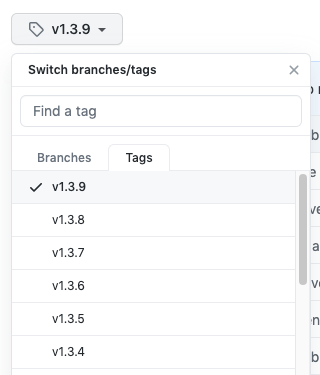</body></html>
<img src = "images/C4W4_LN2_image11.PNG" height="250" width="250">
<center><b>Figure 1: Reference Tag 1.3.9 on github</b></center>



While Trax uses classes liberally, we have not built many classes in the course so far. Let's spend a few moments reviewing the classes we will be using.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>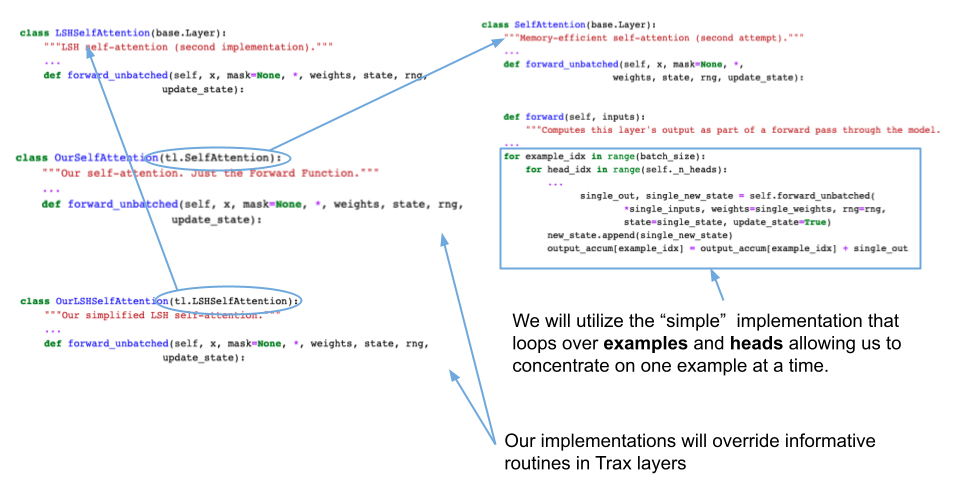</body></html>
<img src = "images/C4W4_LN2_image1.PNG" height="788" width="1561">

<center><b>Figure 2: Classes from Trax/layers/Research/Efficient_Attention.py that we will be utilizing.</b></center>




Starting on the right in the diagram above you see `SelfAttention` that is a 'traditional' implementation of the dot product attention. The parent to this class is the `base.layer` which has the routines used by all layers. `SelfAttention` has an important feature in the *Forward* routine. It supports a `use_reference_code` capability that selects implementations that limit some of the complexities to provide a more easily understood version of the algorithms. In particular, it implements a nested loop that treats each *'example, head'* independently. This simplifies our work as we need only worry about matrix operations on one *'example, head'* at a time. This loop calls *forward_unbatched*, which is the child process that we will be overriding.

We will be implementing the *forward_unbatched* version of `SelfAttention` to highlight the differences between this and the LSH implementation.

On the top left is the `LSHSelfAttention`. This is the routine used in the Reformer architecture. We will override the *forward_unbatched* section of this and some of the utility functions it uses to explore its implementation in more detail.


The code we will be working with is from the Trax source, and as such has implementation details that will make it a bit harder to follow. However, it will allow use of the results along with the rest of the Trax infrastructure. I will try to briefly describe these as they arise. The [Trax documentation](https://trax-ml.readthedocs.io/en/latest/) can also be referenced.

<a name="1.2"></a>
## Part 1.2  Trax Details
The goal in this notebook is to override a few routines in the Trax classes with our own versions. To maintain their functionality in a full Trax environment, many of the details we might ignore in example version of routines will be maintained in this code. Here are some of the considerations that may impact our code:
* Trax operates with multiple back-end libraries, we will see special cases that will utilize unique features.
* 'Fancy' numpy indexing is not supported in all backend environments and must be emulated in other ways.
* Some operations don't have gradients for backprop and must be ignored or include forced re-evaluation.

Here are some of the functions we may see:
* Abstracted as `fastmath`, Trax supports multiple backends such as [Jax](https://github.com/google/jax) and [Tensorflow2](https://github.com/tensorflow/tensorflow)
* [tie_in](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.tie_in.html): Some non-numeric operations must be invoked during backpropagation. Normally, the gradient compute graph would determine invocation but these functions are not included. To force re-evaluation, they are 'tied' to other numeric operations using tie_in.
* [stop_gradient](https://trax-ml.readthedocs.io/en/latest/trax.fastmath.html): Some operations are intentionally excluded from backprop gradient calculations by setting their gradients to zero.
* Below we will execute `from trax.fastmath import numpy as np `, this uses accelerated forms of numpy functions. This is, however a *subset* of numpy

In [1]:
import os
import trax
from trax import layers as tl  # core building block
import jax
from trax import fastmath  # uses jax, offers numpy on steroids


# fastmath.use_backend('tensorflow-numpy')
import functools
from trax.fastmath import numpy as np  # note, using fastmath subset of numpy!
from trax.layers import (
    #tie_in,
    length_normalized,
    apply_broadcasted_dropout,
    look_adjacent,
    permute_via_gather,
    permute_via_sort,
)

from jax.lax import tie_in

<a name="2"></a>
## Part 2  Full Dot-Product Self Attention
<a name="1.2"></a>
### Part 2.1 Description
<img src = "images/C4W4_LN2_image2.PNG" height="200" width="600">

<center><b>Figure 3: Project datapath and primary data structures and where they are implemented</b></center>

The diagram above shows many of the familiar data structures and operations related to attention and describes the routines in which they are implemented. We will start by working on *our_simple_attend* or our simpler version of the original *attend* function. We will review the steps in performing dot-product attention with more focus on the details of the operations and their significance. This is useful when comparing to LSH attention. Note we will be discussing a single example/head unless otherwise specified.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>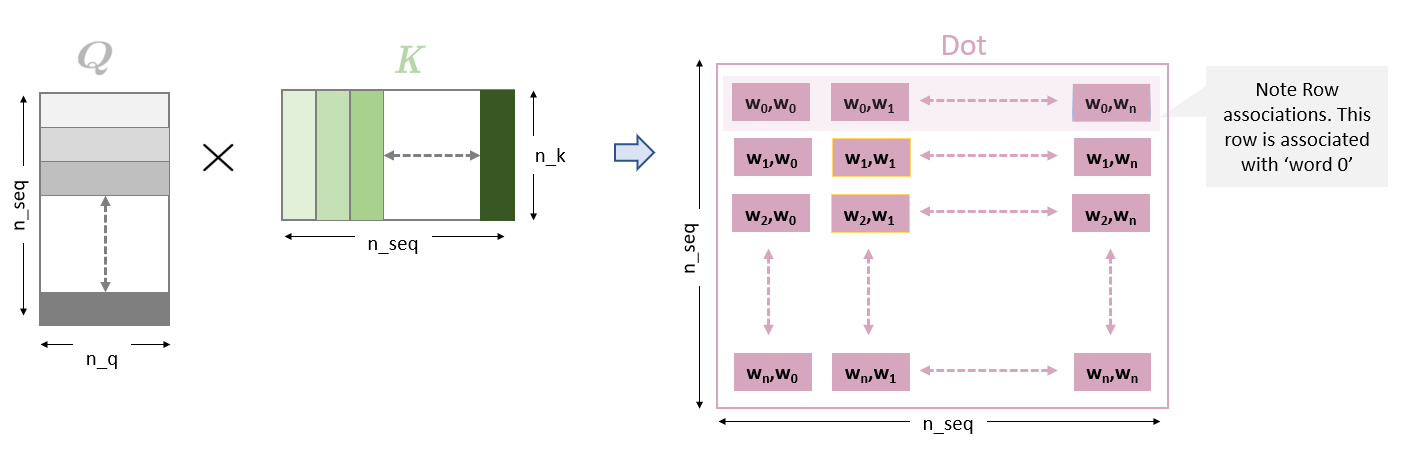</body></html>
<img src = "images/C4W4_LN2_image3.PNG" height="250" width="700">

<center><b>Figure 4: dot-product of Query and Key</b></center>

The *attend* function receives *Query* and *Key*. As a reminder, they are produced by a matrix multiply of all the inputs with a single set of weights. We will describe the inputs as *embeddings* assuming an NLP application, however, this is not required. This matrix multiply works very much like a convolutional network where a set of weights (a filter) slides across the input vectors leaving behind a map of the similarity of the input to the filter. In this case, the filters are the weight matrices $W^Q$ and $W^K$. The resulting maps are Q and K. Q and K have the dimensions of (n_seq, n_q) where n_seq is the number of input embeddings and n_q or n_k is the selected size of the Q or K vectors. Note the shading of Q and K, this reflects the fact that each entry is associated with a particular input embedding. You will note later in the code that K is optional. Apparently, similar results can be achieved using Query alone saving the compute and storage associated with K. In that case, the dot-product in *attend* is matmul(q,q). Note the resulting dot-product (*Dot*) entries describe a complete (n_seq,n_seq) map of the similarity of all entries of q vs all entries of k. This is reflected in the notation in the dot-product boxes of $w_n$,$w_m$ representing word_n, word_m. Note that each row of *Dot* describes the relationship of an input embedding, say $w_0$, with every other input.


In some applications some values are masked. This can be used, for example to exclude results that occur later in time (causal) or to mask padding or other inputs.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>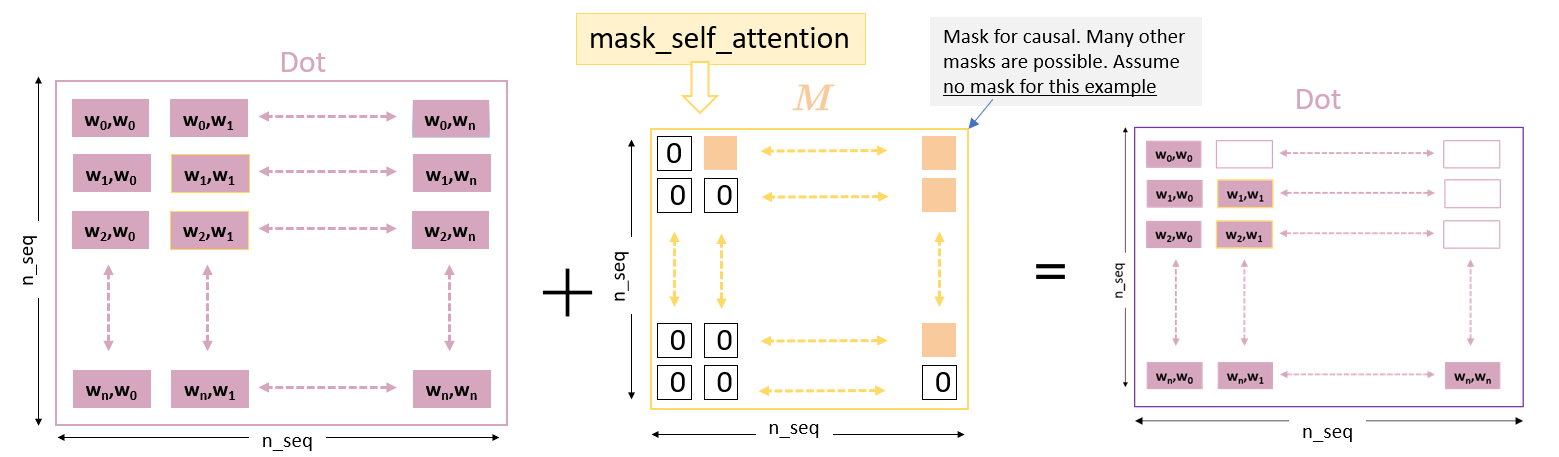</body></html>
<img src = "images/C4W4_LN2_image4.PNG" height="300" width="900">

<center><b>Figure 5: Masking</b></center>


The routine below *mask_self_attention* implements a flexible masking capability. The masking is controlled by the information in q_info and kv_info.

In [2]:
def mask_self_attention(
    dots, q_info, kv_info, causal=True, exclude_self=True, masked=False
):
    """Performs masking for self-attention."""
    if causal:
        mask = fastmath.lt(q_info, kv_info).astype(np.float32)
        dots = dots - 1e9 * mask
    if exclude_self:
        mask = np.equal(q_info, kv_info).astype(np.float32)
        dots = dots - 1e5 * mask
    if masked:
        zeros_like_kv_info = tie_in(kv_info, np.zeros_like(kv_info))
        mask = fastmath.lt(kv_info, zeros_like_kv_info).astype(np.float32)
        dots = dots - 1e9 * mask
    return dots

A SoftMax is applied per row of the *Dot* matrix to scale the values in the row between 0 and 1.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>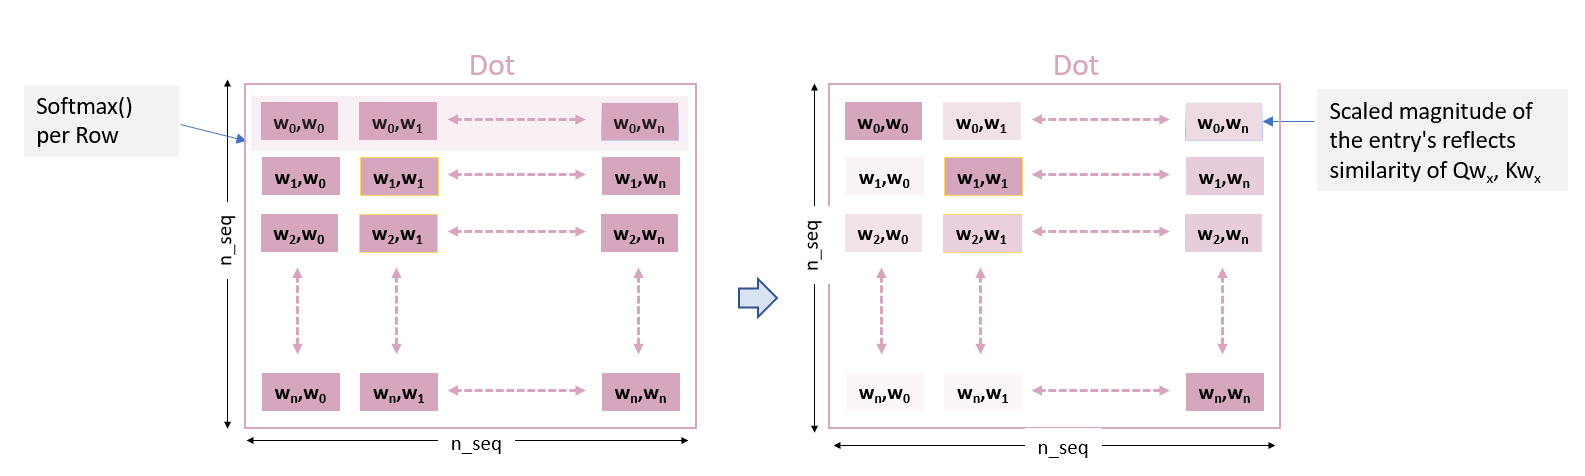</body></html>
<img src = "images/C4W4_LN2_image5.PNG" height="300" width="900">

<center><b>Figure 6: SoftMax per row of Dot</b></center>


<a name="2.1.1"></a>
### Part 2.1.1 our_softmax

This code uses a separable form of the softmax calculation. Recall the softmax:
$$ softmax(x_i)=\frac{\exp(x_i)}{\sum_j \exp(x_j)}\tag{1}$$
This can be alternately implemented as:
$$ logsumexp(x)=\log{({\sum_j \exp(x_j)})}\tag{2}$$
$$ softmax(x_i)=\exp({x_i - logsumexp(x)})\tag{3}$$
The work below will maintain a copy of the logsumexp allowing the softmax to be completed in sections. You will see how this is useful later in the LSHSelfAttention class.
We'll create a routine to implement that here with the addition of a passthrough. The matrix operations we will be working on below are easier to follow if we can maintain integer values. So, for tests, we will skip the softmax in some cases.

In [3]:
def our_softmax(x, passthrough=False):
    """ softmax with passthrough"""
    logsumexp = fastmath.logsumexp(x, axis=-1, keepdims=True)
    o = np.exp(x - logsumexp)
    if passthrough:
        return (x, np.zeros_like(logsumexp))
    else:
        return (o, logsumexp)

Let's check our implementation.

In [4]:
## compare softmax(a) using both methods
a = np.array([1.0, 2.0, 3.0, 4.0])
sma = np.exp(a) / sum(np.exp(a))
print(sma)
sma2, a_logsumexp = our_softmax(a)
print(sma2)
print(a_logsumexp)

[0.0320586  0.08714432 0.2368828  0.6439142 ]
[0.0320586  0.08714431 0.23688279 0.64391416]
[4.44019]


The purpose of the dot-product is to 'focus attention' on some of the inputs. Dot now has entries appropriately scaled to enhance some values and reduce others. These are now applied to the $V$ entries.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>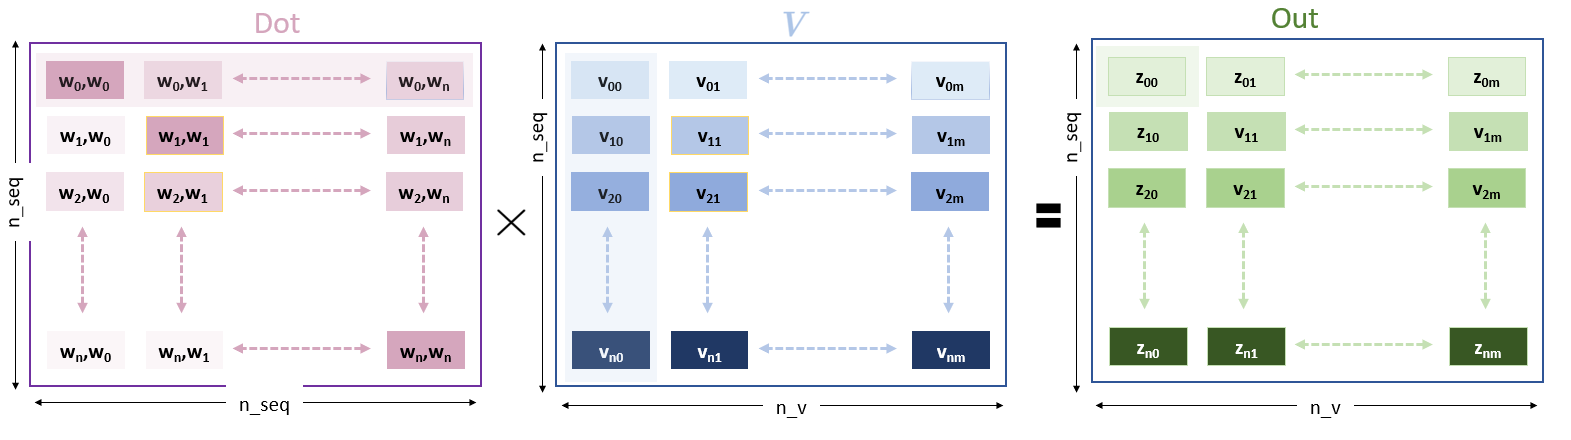</body></html>
<img src = "images/C4W4_LN2_image6.PNG" height="300" width="900">

<center><b>Figure 7: Applying Attention to $V$</b></center>

$V$ is of size (n_seq,n_v). Note the shading in the diagram. This is to draw attention to the operation of the matrix multiplication. This is detailed below.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>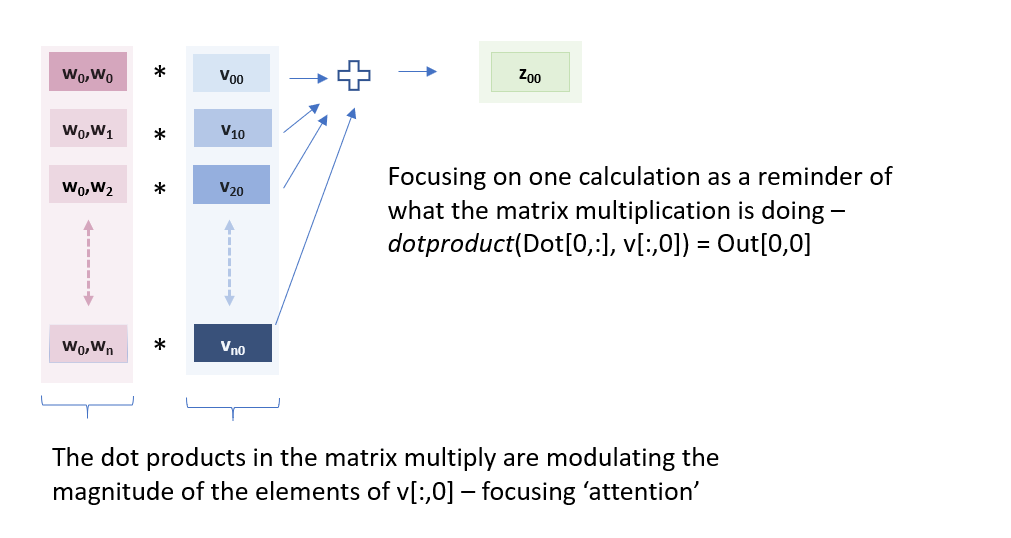</body></html>
<img src = "images/C4W4_LN2_image7.PNG" height="300" width="600"/>

<center><b>Figure 7: The Matrix Multiply applies attention to the values of V</b></center>

$V$ is formed by a matrix multiply of the input embedding with the weight matrix $W^v$ whose values were set by backpropagation. The row entries of $V$ are then related to the corresponding input embedding. The matrix multiply weights first column of V, representing a section of each of the input embeddings, with the first row of Dot, representing the similarity of $W_0$ and each word of the input embedding and deposits the value in $Z$

<a name="2.2"></a>
### Part 2.2  our_simple_attend
In this section we'll work on an implementation of *attend* whose operations you can see in figure 3. It is a slightly simplified version of the routine in [efficient_attention.py](https://github.com/google/trax/blob/v1.3.4/trax/layers/research/efficient_attention.py). We will fill in a few lines of code. The main goal is to become familiar with the routine. You have implemented similar functionality in a previous assignment.

**Instructions**
**Step 1:** matrix multiply (np.matmul) q and the k 'transpose' kr.
**Step 2:** use our_softmax() to perform a softmax on masked output of the dot product, dots.
**Step 3:** matrix multiply (np.matmul) dots and v.

In [5]:
def our_simple_attend(
    q,
    k=None,
    v=None,
    mask_fn=None,
    q_info=None,
    kv_info=None,
    dropout=0.0,
    rng=None,
    verbose=False,
    passthrough=False,
):
    """Dot-product attention,  with masking, without optional chunking and/or.

  Args:
    q: Query vectors, shape [q_len, d_qk]
    k: Key vectors, shape [kv_len, d_qk]; or None
    v: Value vectors, shape [kv_len, d_v]
    mask_fn: a function reference that implements masking (e.g. mask_self_attention)
    q_info: Query-associated metadata for masking
    kv_info: Key-associated metadata for masking
    dropout: Dropout rate
    rng: RNG for dropout

  Returns:
    A tuple (output, dots_logsumexp). The output has shape [q_len, d_v], and
    dots_logsumexp has shape [q_len]. The logsumexp of the attention
    probabilities is useful for combining multiple rounds of attention (as in
    LSH attention).
  """
    assert v is not None
    share_qk = k is None
    if share_qk:
        k = q
        if kv_info is None:
            kv_info = q_info

    if share_qk:
        k = length_normalized(k)
    k = k / np.sqrt(k.shape[-1])

    # Dot-product attention.
    kr = np.swapaxes(k, -1, -2)  # note the fancy transpose for later..

    ## Step 1  ##
    dots = None
    if verbose:
        print("Our attend dots", dots.shape)

    # Masking
    if mask_fn is not None:
        dots = mask_fn(dots, q_info[..., :, None], kv_info[..., None, :])

    # Softmax.
    # dots_logsumexp = fastmath.logsumexp(dots, axis=-1, keepdims=True)  #original
    # dots = np.exp(dots - dots_logsumexp)  #original
    ## Step 2  ##
    # replace with our_softmax()
    dots, dots_logsumexp = None
    if verbose:
        print("Our attend dots post softmax", dots.shape, dots_logsumexp.shape)

    if dropout > 0.0:
        assert rng is not None
        # Dropout is broadcast across the bin dimension
        dropout_shape = (dots.shape[-2], dots.shape[-1])
        keep_prob = tie_in(dots, 1.0 - dropout)
        keep = fastmath.random.bernoulli(rng, keep_prob, dropout_shape)
        multiplier = keep.astype(dots.dtype) / tie_in(keep, keep_prob)
        dots = dots * multiplier

    ## Step 3  ##
    # The softmax normalizer (dots_logsumexp) is used by multi-round LSH attn.
    out = None
    if verbose:
        print("Our attend out1", out.shape)
    out = np.reshape(out, (-1, out.shape[-1]))
    if verbose:
        print("Our attend out2", out.shape)
    dots_logsumexp = np.reshape(dots_logsumexp, (-1,))
    return out, dots_logsumexp

In [8]:
seq_len = 8
emb_len = 5
d_qk = 3
d_v = 4
with fastmath.use_backend("jax"):  # specify the backend for consistency
    rng_attend = fastmath.random.get_prng(1)
    q = k = jax.random.uniform(rng_attend, (seq_len, d_qk), dtype=np.float32)
    v = jax.random.uniform(rng_attend, (seq_len, d_v), dtype=np.float32)
    o, logits = our_simple_attend(
        q,
        k,
        v,
        mask_fn=None,
        q_info=None,
        kv_info=None,
        dropout=0.0,
        rng=rng_attend,
        verbose=True,
    )
print(o, "\n", logits)

AttributeError: 'NoneType' object has no attribute 'shape'

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Output**
```
Our attend dots (8, 8)
Our attend dots post softmax (8, 8) (8, 1)
Our attend out1 (8, 4)
Our attend out2 (8, 4)
[[0.5606324  0.7290605  0.5251243  0.47101074]
 [0.5713517  0.71991956 0.5033342  0.46975708]
 [0.5622886  0.7288458  0.52172124 0.46318397]
 [0.5568317  0.72234154 0.542236   0.4699722 ]
 [0.56504494 0.72274375 0.5204978  0.47231334]
 [0.56175965 0.7216782  0.53293145 0.48003793]
 [0.56753993 0.72232544 0.5141734  0.46625748]
 [0.57100445 0.70785505 0.5325362  0.4590797 ]]
 [2.6512175 2.1914332 2.6630518 2.7792363 2.4583826 2.5421977 2.4145055
 2.5111294]
```

<details>
<summary>
    <font size="3"><b> completed code for reference </b></font>
</summary>
    This notebook is ungraded, so for reference, the completed code follows:

```python
def our_simple_attend(
    q,
    k=None,
    v=None,
    mask_fn=None,
    q_info=None,
    kv_info=None,
    dropout=0.0,
    rng=None,
    verbose=False,
    passthrough=False,
):
    """Dot-product attention,  with masking, without optional chunking and/or.

  Args:
    q: Query vectors, shape [q_len, d_qk]
    k: Key vectors, shape [kv_len, d_qk]; or None
    v: Value vectors, shape [kv_len, d_v]
    mask_fn: a function reference that implements masking (e.g. mask_self_attention)
    q_info: Query-associated metadata for masking
    kv_info: Key-associated metadata for masking
    dropout: Dropout rate
    rng: RNG for dropout

  Returns:
    A tuple (output, dots_logsumexp). The output has shape [q_len, d_v], and
    dots_logsumexp has shape [q_len]. The logsumexp of the attention
    probabilities is useful for combining multiple rounds of attention (as in
    LSH attention).
  """
    assert v is not None
    share_qk = k is None
    if share_qk:
        k = q
        if kv_info is None:
            kv_info = q_info

    if share_qk:
        k = length_normalized(k)
    k = k / np.sqrt(k.shape[-1])

    # Dot-product attention.
    kr = np.swapaxes(k, -1, -2)  # note the fancy transpose for later..

    ## Step 1  ##
    dots = np.matmul(q, kr )
    if verbose:
        print("Our attend dots", dots.shape)

    # Masking
    if mask_fn is not None:
        dots = mask_fn(dots, q_info[..., :, None], kv_info[..., None, :])

    # Softmax.
    # dots_logsumexp = fastmath.logsumexp(dots, axis=-1, keepdims=True)  #original
    # dots = np.exp(dots - dots_logsumexp)  #original
    ## Step 2  ##
    # replace with our_softmax()
    dots, dots_logsumexp = our_softmax(dots, passthrough=passthrough)
    if verbose:
        print("Our attend dots post softmax", dots.shape, dots_logsumexp.shape)

    if dropout > 0.0:
        assert rng is not None
        # Dropout is broadcast across the bin dimension
        dropout_shape = (dots.shape[-2], dots.shape[-1])
        keep_prob = tie_in(dots, 1.0 - dropout)
        keep = fastmath.random.bernoulli(rng, keep_prob, dropout_shape)
        multiplier = keep.astype(dots.dtype) / tie_in(keep, keep_prob)
        dots = dots * multiplier

    ## Step 3  ##
    # The softmax normalizer (dots_logsumexp) is used by multi-round LSH attn.
    out = np.matmul(dots, v)
    if verbose:
        print("Our attend out1", out.shape)
    out = np.reshape(out, (-1, out.shape[-1]))
    if verbose:
        print("Our attend out2", out.shape)
    dots_logsumexp = np.reshape(dots_logsumexp, (-1,))
    return out, dots_logsumexp
```

<a name="2.3"></a>
## Part 2.3  Class OurSelfAttention
Here we create our own self attention layer by creating a class `OurSelfAttention`. The parent class will be the tl.SelfAttention layer in Trax. We will only override the `forward_unbatched` routine.
We're not asking you to modify anything in this routine. There are some comments to draw your attention to a few lines.

In [9]:
class OurSelfAttention(tl.SelfAttention):
    """Our self-attention. Just the Forward Function."""

    def forward_unbatched(
        self, x, mask=None, *, weights, state, rng, update_state, verbose=False
    ):
        print("ourSelfAttention:forward_unbatched")
        del update_state
        attend_rng, output_rng = fastmath.random.split(rng)
        if self._bias:
            if self._share_qk:
                w_q, w_v, w_o, b_q, b_v = weights
            else:
                w_q, w_k, w_v, w_o, b_q, b_k, b_v = weights
        else:
            if self._share_qk:
                w_q, w_v, w_o = weights
            else:
                w_q, w_k, w_v, w_o = weights

        print("x.shape,w_q.shape", x.shape, w_q.shape)
        q = np.matmul(x, w_q)
        k = None
        if not self._share_qk:
            k = np.matmul(x, w_k)
        v = np.matmul(x, w_v)

        if self._bias:
            q = q + b_q
            if not self._share_qk:
                k = k + b_k
            v = v + b_v

        mask_fn = functools.partial(
            mask_self_attention,
            causal=self._causal,
            exclude_self=self._share_qk,
            masked=self._masked,
        )
        q_info = kv_info = tie_in(x, np.arange(q.shape[-2], dtype=np.int32))

        assert (mask is not None) == self._masked
        if self._masked:
            # mask is a boolean array (True means "is valid token")
            ones_like_mask = tie_in(x, np.ones_like(mask, dtype=np.int32))
            kv_info = kv_info * np.where(mask, ones_like_mask, -ones_like_mask)

        # Notice, we are calling our vesion of attend
        o, _ = our_simple_attend(
            q,
            k,
            v,
            mask_fn=mask_fn,
            q_info=q_info,
            kv_info=kv_info,
            dropout=self._attention_dropout,
            rng=attend_rng,
            verbose=True,
        )

        # Notice, wo weight matrix applied to output of attend in forward_unbatched
        out = np.matmul(o, w_o)
        out = apply_broadcasted_dropout(out, self._output_dropout, output_rng)
        return out, state

In [10]:
causal = False
masked = False
mask = None
attention_dropout = 0.0
n_heads = 3
d_qk = 3
d_v = 4
seq_len = 8
emb_len = 5
batch_size = 1

osa = OurSelfAttention(
    n_heads=n_heads,
    d_qk=d_qk,
    d_v=d_v,
    causal=causal,
    use_reference_code=True,
    attention_dropout=attention_dropout,
    mode="train",
)

rng_osa = fastmath.random.get_prng(1)
x = jax.random.uniform(
    jax.random.PRNGKey(0), (batch_size, seq_len, emb_len), dtype=np.float32
)
_, _ = osa.init(tl.shapes.signature(x), rng=rng_osa)

In [11]:
osa(x)

ourSelfAttention:forward_unbatched
x.shape,w_q.shape (8, 5) (5, 3)


LayerError: Exception passing through layer OurSelfAttention (in pure_fn):
  layer created in file [...]/layers/research/efficient_attention.py, line 1011
  layer input shapes: ShapeDtype{shape:(1, 8, 5), dtype:float32}

  File [...]/layers/research/efficient_attention.py, line 1320, in forward
    state=single_state, update_state=True)

  File [...]/<ipython-input-9-6a4356fa4ece>, line 58, in forward_unbatched
    verbose=True,

  File [...]/<ipython-input-5-5e57c9b13d0e>, line 48, in our_simple_attend
    print("Our attend dots", dots.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Output**
Notice a few things:
* the w_q (and w_k) matrices are applied to each row or each embedding on the input. This is similar to the filter operation in convolution
* forward_unbatched is called 3 times. This is because we have 3 heads in this example.

```
ourSelfAttention:forward_unbatched
x.shape,w_q.shape (8, 5) (5, 3)
Our attend dots (8, 8)
Our attend dots post softmax (8, 8) (8, 1)
Our attend out1 (8, 4)
Our attend out2 (8, 4)
ourSelfAttention:forward_unbatched
x.shape,w_q.shape (8, 5) (5, 3)
Our attend dots (8, 8)
Our attend dots post softmax (8, 8) (8, 1)
Our attend out1 (8, 4)
Our attend out2 (8, 4)
ourSelfAttention:forward_unbatched
x.shape,w_q.shape (8, 5) (5, 3)
Our attend dots (8, 8)
Our attend dots post softmax (8, 8) (8, 1)
Our attend out1 (8, 4)
Our attend out2 (8, 4)
DeviceArray([[[ 6.70414150e-01, -1.04319841e-01, -5.33822298e-01,
                1.92711830e-01, -4.52995300e-05],
              [ 6.64090276e-01, -1.01875424e-01, -5.35732985e-01,
                1.88311636e-01, -6.30623102e-03],
              [ 6.73379958e-01, -1.06952399e-01, -5.31989932e-01,
                1.90056771e-01,  1.30265951e-03],
              [ 6.84564888e-01, -1.13240302e-01, -5.50182462e-01,
                1.95673436e-01,  5.47635555e-03],
              [ 6.81435883e-01, -1.11069024e-01, -5.32343268e-01,
                1.91912323e-01,  5.69400191e-03],
              [ 6.80724978e-01, -1.08496964e-01, -5.34994245e-01,
                1.96332291e-01,  5.89764118e-03],
              [ 6.80933297e-01, -1.14087194e-01, -5.18660128e-01,
                1.90674156e-01,  1.14096403e-02],
              [ 6.80265129e-01, -1.09031767e-01, -5.38248658e-01,
                1.94203168e-01,  4.23955917e-03]]], dtype=float32)
```



<a name="3"></a>
## Part 3.0 Trax LSHSelfAttention
<a name="3.1"></a>
## Part 3.1 Description
The larger the matrix multiply in the previous section is, the more context can be taken into account when making the next decision. However, the self attention dot product grows as the size of the input squared. For example, if one wished to have an input size of 1024, that would result in $1024^2$ or over a million dot products for each head! As a result, there has been significant research related to reducing the compute requirements. One such approach is Locality Sensitive Hashing (LSH) Self Attention.

You may recall, earlier in the course you utilized LSH to find similar tweets without resorting to calculating cosine similarity for each pair of embeddings. We will use a similar approach here. It may be best described with an example.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>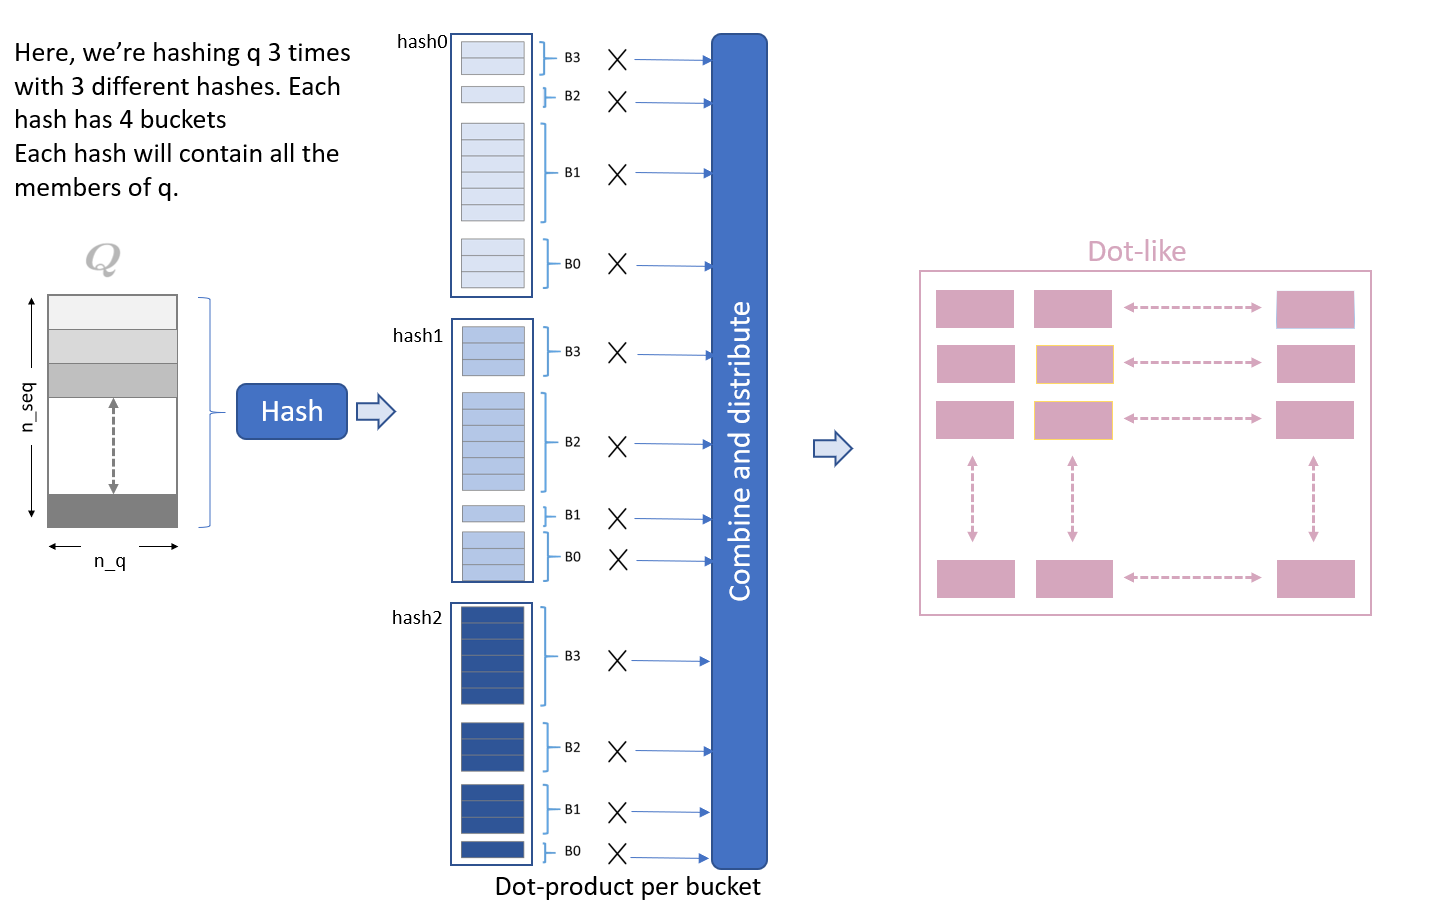</body></html>
<img src = "images/C4W4_LN2_image8.PNG" height="400" width="750">

<center><b>Figure 9: Example of LSH Self Attention</b></center>



LSH Self attention uses Queries only, no Keys. Attention then generates a metric of the similarity of each value of Q relative to all the other values in Q. An earlier assignment demonstrated that values which hash to the same bucket are likely to be similar. Further, multiple random hashes can improve the chances of finding entries which are similar. This is the approach taken here, though the hash is implemented a bit differently. The values of Q are hashed into buckets using a randomly generated set of hash vectors.  Multiple sets of hash vectors are used, generating multiple hash tables. In the figure above, we have 3 hash tables with 4 buckets in each table. Notionally,  following the hash, the values of Q have been replicated 3 times and distributed to their appropriate bucket in each of the 3 tables. To find similarity then, one generates dot-products only between members of the buckets. The result of this operation provides information on which entries are similar. As the operation has been distributed over multiple hash tables, these results need to be combined to form a complete picture and this can be used to generate a reduced dot-product attention array. Its clear that because we do not do a compare of every value vs every other value, the size of *Dots* will be reduced.

The challenge in this approach is getting it to operate efficiently. You may recall from the earlier assignments the buckets were lists of entries and had varying length. This will operate poorly on a vector processing machine such as a GPU or TPU. Ideally, operations are done in large blocks with uniform sizes. While it is straightforward to implement the hash algorithm this way, it is challenging to managed buckets and variable sized dot-products. This will be discussed further below. For now, we will examine and implement the hash function.

<a name="3.2"></a>
## Part 3.2 our_hash_vectors

*our_hash_vectors*, is a reimplementation of Trax *hashvector*. It takes in an array of vectors, hashes the entries and returns and array assigning each input vector to n_hash buckets. Hashing is described as creating *random rotations*, see [Practical and Optimal LSH for Angular Distance](https://arxiv.org/pdf/1509.02897.pdf).
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>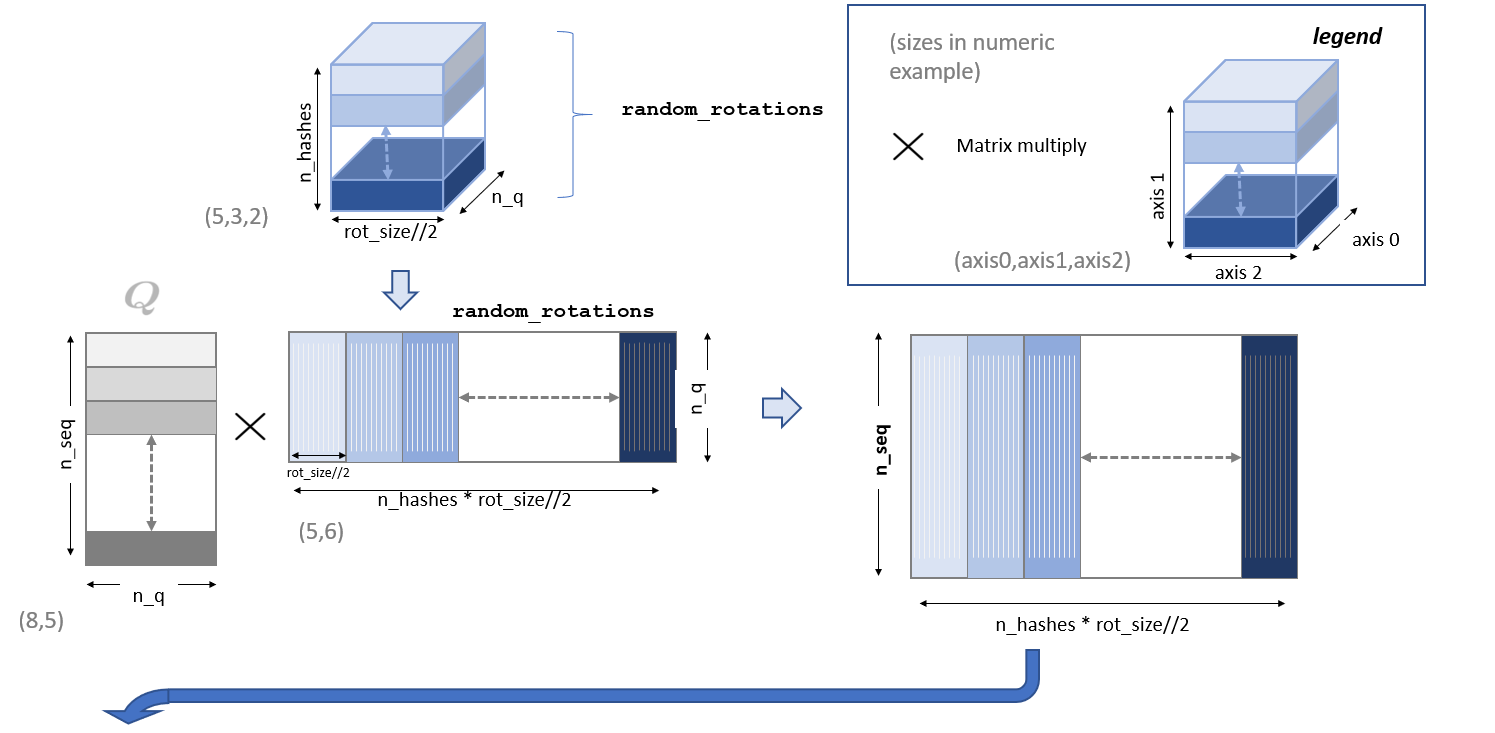</body></html>
<img src = "images/C4W4_LN2_image9.PNG" height="400" width="750">
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>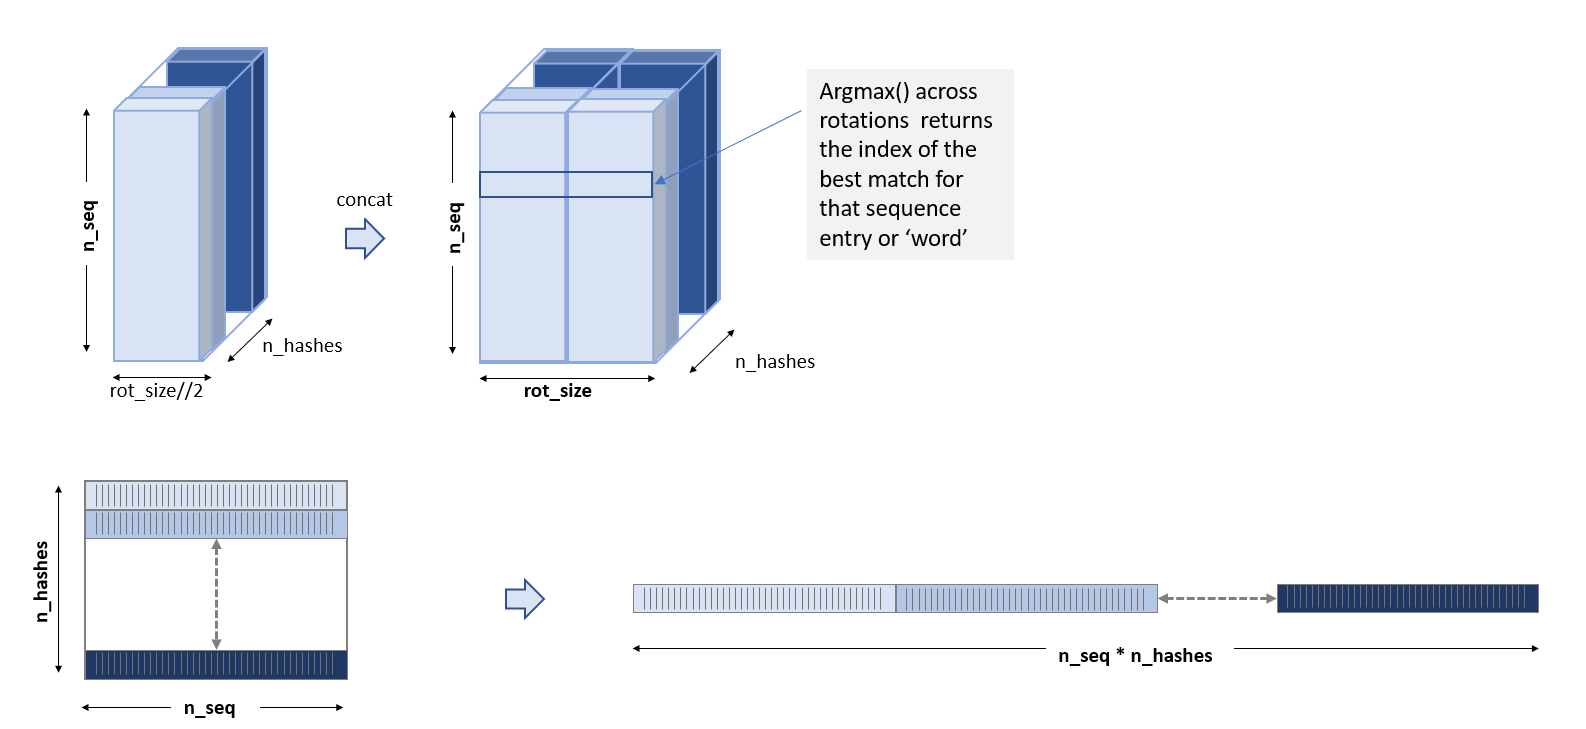</body></html>
<img src = "images/C4W4_LN2_image10.PNG" height="400" width="750">
<center><b>Figure 10: Processing steps in our_hash_vectors </b></center>

Note, in the diagram, sizes relate to our expected input $Q$ while our_hash_vectors is written assuming a generic input vector


**Instructions**

**Step 1**
create an array of random normal vectors which will be our hash vectors. Each vector will be hashed into a hash table and into `rot_size//2` buckets. We use `rot_size//2` to reduce computation. Later in the routine we will form the negative rotations with a simple negation and concatenate to get a full `rot_size` number of rotations.
    
* use fastmath.random.normal and create an array of random vectors of shape `(vecs.shape[-1],n_hashes, rot_size//2)`

**Step 2** In this step we simply do the matrix multiply. `jax` has an accelerated version of [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html). Here we will utilize more conventional routines.

**Step 2x**
    
* 2a: `np.reshape` random_rotations into a 2 dimensional array (`[-1, n_hashes * (rot_size // 2)]`)
* 2b: `np.dot` vecs and random_rotations forming our rotated_vecs
* 2c: back to 3 dimension with `np.reshape` `[-1, n_hashes, rot_size//2]`
* 2d: prepare for concatenating by swapping dimensions np.transpose `(1, 0, 2)`

**Step 3** Here we concatenate our rotation vectors getting a fullrot_size number of buckets (note, n_buckets = rotsize)
* use `np.concatenate`, `[rotated_vecs, -rotated_vecs]`, `axis=-1`
    
**Step 4** **This is the exciting step!** You have no doubt been wondering how we will turn these vectors into bucket indexes. By performing `np.argmax` over the rotations for a given entry, you get the index to the best match! We will use this as a bucket index.
* `np.argmax(...).astype(np.int32)`; be sure to use the correct axis!

**Step 5** In this style of hashing, items which land in bucket 0 of hash table 0 are not necessarily similar to those landing in bucket 0 of hash table 1, so we keep them separate. We do this by offsetting the bucket numbers by `n_buckets`.
* add buckets and offsets and reshape into a one dimensional array.
This will return a 1D array of size `n_hashes * vec.shape[0]`.

In [12]:
def our_hash_vectors(vecs, rng, n_buckets, n_hashes, mask=None, verbose=False):
    """ 
  Args:
    vecs: tensor of at least 2 dimension, 
    rng: random number generator
    n_buckets: number of buckets in each hash table
    n_hashes: the number of hash tables
    mask: None indicating no mask or a 1D boolean array of length vecs.shape[0], containing the location of padding value
    verbose: controls prints for debug
  Returns:
    A vector of size n_hashes * vecs.shape[0] containing the buckets associated with each input vector per hash table.
    
    """

    # check for even, integer bucket sizes
    assert isinstance(n_buckets, int) and n_buckets % 2 == 0

    rng = fastmath.stop_gradient(tie_in(vecs, rng))
    rot_size = n_buckets
    ### Start Code Here

    ### Step 1 ###
    rotations_shape = None
    random_rotations = fastmath.random.normal(rng, rotations_shape).astype(np.float32)
    if verbose:
        print("random.rotations.shape", random_rotations.shape)

    ### Step 2 ###
    if fastmath.backend_name() == "jax":
        rotated_vecs = np.einsum("tf,fhb->htb", vecs, random_rotations)
        print("using jax")
    else:
        # Step 2a
        random_rotations = None
        if verbose:
            print("random_rotations reshaped", random_rotations.shape)
        # Step 2b
        rotated_vecs = None
        if verbose:
            print("rotated_vecs1", rotated_vecs.shape)
        # Step 2c
        rotated_vecs = None
        if verbose:
            print("rotated_vecs2", rotated_vecs.shape)
        # Step 2d
        rotated_vecs = None
        if verbose:
            print("rotated_vecs3", rotated_vecs.shape)

    ### Step 3 ###
    rotated_vecs = None
    if verbose:
        print("rotated_vecs.shape", rotated_vecs.shape)
    ### Step 4 ###
    buckets = None
    if verbose:
        print("buckets.shape", buckets.shape)
    if verbose:
        print("buckets", buckets)

    if mask is not None:
        n_buckets += 1  # Create an extra bucket for padding tokens only
        buckets = np.where(mask[None, :], buckets, n_buckets - 1)

    # buckets is now (n_hashes, seqlen). Next we add offsets so that
    # bucket numbers from different hashing rounds don't overlap.
    offsets = tie_in(buckets, np.arange(n_hashes, dtype=np.int32))
    offsets = np.reshape(offsets * n_buckets, (-1, 1))
    ### Step 5 ###
    buckets = None
    if verbose:
        print("buckets with offsets", buckets.shape, "\n", buckets)
    ### End Code Here
    return buckets

In [13]:
# example code. Note for reference, the sizes in this example match the values in the diagram above.
ohv_q = np.ones((8, 5))  # (seq_len=8, n_q=5)
ohv_n_buckets = 4  # even number
ohv_n_hashes = 3

with fastmath.use_backend("tensorflow-numpy"):
    ohv_rng = fastmath.random.get_prng(1)
    ohv = our_hash_vectors(
        ohv_q, ohv_rng, ohv_n_buckets, ohv_n_hashes, mask=None, verbose=True
    )
    print("ohv shape", ohv.shape, "\nohv", ohv)  # (ohv_n_hashes * ohv_n_buckets)

# note the random number generators do not produce the same results with different backends
with fastmath.use_backend("jax"):
    ohv_rng = fastmath.random.get_prng(1)
    ohv = our_hash_vectors(ohv_q, ohv_rng, ohv_n_buckets, ohv_n_hashes, mask=None)
    print("ohv shape", ohv.shape, "\nohv", ohv)  # (ohv_n_hashes * ohv_n_buckets)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Values**
```
random.rotations.shape (5, 3, 2)
random_rotations reshaped (5, 6)
rotated_vecs1 (8, 6)
rotated_vecs2 (8, 3, 2)
rotated_vecs3 (3, 8, 2)
rotated_vecs.shape (3, 8, 4)
buckets.shape (3, 8)
buckets ndarray<tf.Tensor(
[[3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3]
 [3 3 3 3 3 3 3 3]], shape=(3, 8), dtype=int32)>
buckets with offsets (24,)
 ndarray<tf.Tensor([ 3  3  3  3  3  3  3  3  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11], shape=(24,), dtype=int32)>
ohv shape (24,)
ohv ndarray<tf.Tensor([ 3  3  3  3  3  3  3  3  7  7  7  7  7  7  7  7 11 11 11 11 11 11 11 11], shape=(24,), dtype=int32)>
using jax
ohv shape (24,)
ohv [ 3  3  3  3  3  3  3  3  5  5  5  5  5  5  5  5 11 11 11 11 11 11 11 11]
```

<details>
<summary>
    <font size="3" ><b>Completed code for reference </b></font>
</summary>

Since this notebook is ungraded the completed code is provided here for reference
    
    
```python
def our_hash_vectors(vecs, rng, n_buckets, n_hashes, mask=None, verbose=False):
    """
  Args:
    vecs: tensor of at least 2 dimension,
    rng: random number generator
    n_buckets: number of buckets in each hash table
    n_hashes: the number of hash tables
    mask: None indicating no mask or a 1D boolean array of length vecs.shape[0], containing the location of padding value
    verbose: controls prints for debug
  Returns:
    A vector of size n_hashes * vecs.shape[0] containing the buckets associated with each input vector per hash table.

    """

    # check for even, integer bucket sizes
    assert isinstance(n_buckets, int) and n_buckets % 2 == 0

    rng = fastmath.stop_gradient(tie_in(vecs, rng))
    rot_size = n_buckets
    ### Start Code Here

    ### Step 1 ###
    rotations_shape = (vecs.shape[-1], n_hashes, rot_size // 2)
    random_rotations = fastmath.random.normal(rng, rotations_shape).astype(
        np.float32)
    if verbose: print("random.rotations.shape", random_rotations.shape)

    ### Step 2 ###
    if fastmath.backend_name() == 'jax':
        rotated_vecs = np.einsum('tf,fhb->htb', vecs, random_rotations)
        if verbose: print("using jax")
    else:
        #Step 2a
        random_rotations = np.reshape(random_rotations,
                                    [-1, n_hashes * (rot_size // 2)])
        if verbose: print("random_rotations reshaped", random_rotations.shape)
        #Step 2b
        rotated_vecs = np.dot(vecs, random_rotations)
        if verbose: print("rotated_vecs1", rotated_vecs.shape)
        #Step 2c
        rotated_vecs = np.reshape(rotated_vecs, [-1, n_hashes, rot_size//2])
        if verbose: print("rotated_vecs2", rotated_vecs.shape)
        #Step 2d
        rotated_vecs = np.transpose(rotated_vecs, (1, 0, 2))
        if verbose: print("rotated_vecs3", rotated_vecs.shape)

    ### Step 3 ###
    rotated_vecs = np.concatenate([rotated_vecs, -rotated_vecs], axis=-1)
    if verbose: print("rotated_vecs.shape", rotated_vecs.shape)
    ### Step 4 ###
    buckets = np.argmax(rotated_vecs, axis=-1).astype(np.int32)
    if verbose: print("buckets.shape", buckets.shape)
    if verbose: print("buckets", buckets)

    if mask is not None:
        n_buckets += 1  # Create an extra bucket for padding tokens only
        buckets = np.where(mask[None, :], buckets, n_buckets - 1)

    # buckets is now (n_hashes, seqlen). Next we add offsets so that
    # bucket numbers from different hashing rounds don't overlap.
    offsets = tie_in(buckets, np.arange(n_hashes, dtype=np.int32))
    offsets = np.reshape(offsets * n_buckets, (-1, 1))
    ### Step 5 ###
    buckets = np.reshape(buckets + offsets, (-1,))
    if verbose: print("buckets with offsets", buckets.shape, "\n", buckets)
    return buckets
```

<a name="3.3"></a>
## Part 3.3 Sorting Buckets

Great! Now that we have a hash function, we can work on sorting our buckets and performing our matrix operations.
 We'll walk through this algorithm in small steps:
* sort_buckets - we'll perform the sort
* softmax
* dotandv - do the matrix math to form the dotproduct and output

These routines will demonstrate a simplified version of the algorithm. We won't address masking and variable bucket sizes but will consider how they would be handled.

**sort_buckets**

At this point, we have called the hash function and were returned the associated buckets. For example, if we started with
`q[n_seq,n_q]`, with `n_hash = 2; n_buckets = 4; n_seq = 8`
we might be returned:
`bucket = [0,1,2,3,0,1,2,3, 4,5,6,7,4,5,6,7]`. 
Note that it is `n_hash * n_seq` long and that the bucket values for each hash have been offset by `n_hash` so the numbers do not overlap. Going forward, we are going to sort this array of buckets to group together members of the same (hash,bucket) pair.

**Instructions**

**Step 1** Our goal is to sort $q$ rather than the bucket list, so we will need to track the association of the buckets to their elements in $q$.
* using `np.arange`, create `ticker`, just a sequence of numbers (0...n_hashes * seqlen) associating members of $q$ with their bucket.

**Step 2** This step is provided to you as it is a bit difficult to describe. We want to disambiguate elements that map to the same bucket. When a sorting routine encounters a situation where multiple entries have the same value, it can correctly choose any entry to go first. This makes testing ambiguous. This prevents that. We multiply all the buckets by `seqlen` and then add `ticker % seqlen`

**Step 3** Here we are! Ready to sort. This is the exciting part.
* Utilize [fastmath.sort_key_val](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.sort_key_val.html#jax.lax.sort_key_val) and sort `buckets_and_t` and `ticker`.

**Step 4** We need to be able to undo the sort at the end to get things back into their correct locations
* sort `sticker` and `ticker` to for the reverse map

**Step 5** create our sorted q and sorted v
* use [np.take](https://numpy.org/doc/stable/reference/generated/numpy.take.html) and `st` to grab correct values in `q` for the sorted values, `sq`. Use `axis=0`.

Use the example code below the routine to check and help debug your results.

In [14]:
def sort_buckets(buckets, q, v, n_buckets, n_hashes, seqlen, verbose=True):
    """ 
  Args:
    buckets: tensor of at least 2 dimension, 
    n_buckets: number of buckets in each hash table
    n_hashes: the number of hash tables    
    """
    if verbose:
        print("---sort_buckets--")
    ## Step 1
    ticker = None
    if verbose:
        print("ticker", ticker.shape, ticker)
    ## Step 2
    buckets_and_t = seqlen * buckets + (ticker % seqlen)  # provided
    if verbose:
        print("buckets_and_t", buckets_and_t.shape, buckets_and_t)

    # Hash-based sort ("s" at the start of variable names means "sorted")
    # Step 3
    sbuckets_and_t, sticker = None
    if verbose:
        print("sbuckets_and_t", sbuckets_and_t.shape, sbuckets_and_t)
    if verbose:
        print("sticker", sticker.shape, sticker)
    # Step 4
    _, undo_sort = None
    if verbose:
        print("undo_sort", undo_sort.shape, undo_sort)

    # Step 5
    st = sticker % seqlen  # provided
    sq = None
    sv = None
    return sq, sv, sticker, undo_sort

In [15]:
t_n_hashes = 2
t_n_buckets = 4
t_n_seq = t_seqlen = 8
t_n_q = 3
n_v = 5

t_q = (np.array([(j % t_n_buckets) for j in range(t_n_seq)]) * np.ones((t_n_q, 1))).T
t_v = np.ones((t_n_seq, n_v))
t_buckets = np.array(
    [
        (j % t_n_buckets) + t_n_buckets * i
        for i in range(t_n_hashes)
        for j in range(t_n_seq)
    ]
)
print("q\n", t_q)
print("t_buckets: ", t_buckets)

t_sq, t_sv, t_sticker, t_undo_sort = sort_buckets(
    t_buckets, t_q, t_v, t_n_buckets, t_n_hashes, t_seqlen, verbose=True
)

print("sq.shape", t_sq.shape, "sv.shape", t_sv.shape)
print("sq\n", t_sq)

q
 [[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]]
t_buckets:  [0 1 2 3 0 1 2 3 4 5 6 7 4 5 6 7]
---sort_buckets--


AttributeError: 'NoneType' object has no attribute 'shape'

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Values**
```
q
 [[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]]
t_buckets:  [0 1 2 3 0 1 2 3 4 5 6 7 4 5 6 7]
---sort_buckets--
ticker (16,) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
buckets_and_t (16,) [ 0  9 18 27  4 13 22 31 32 41 50 59 36 45 54 63]
sbuckets_and_t (16,) [ 0  4  9 13 18 22 27 31 32 36 41 45 50 54 59 63]
sticker (16,) [ 0  4  1  5  2  6  3  7  8 12  9 13 10 14 11 15]
undo_sort (16,) [ 0  2  4  6  1  3  5  7  8 10 12 14  9 11 13 15]
sq.shape (16, 3) sv.shape (16, 5)
sq
 [[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [2. 2. 2.]
 [2. 2. 2.]
 [3. 3. 3.]
 [3. 3. 3.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [2. 2. 2.]
 [2. 2. 2.]
 [3. 3. 3.]
 [3. 3. 3.]]

```

<details>
<summary>
    <font size="3" ><b>Completed code for reference </b></font>
</summary>

Since this notebook is ungraded the completed code is provided here for reference    
    
```python
def sort_buckets(buckets, q, v, n_buckets, n_hashes, seqlen, verbose=True):
    """
  Args:
    buckets: tensor of at least 2 dimension,
    n_buckets: number of buckets in each hash table
    n_hashes: the number of hash tables
    """
    if verbose: print("---sort_buckets--")
    ## Step 1
    ticker = np.arange(n_hashes * seqlen)
    if verbose: print("ticker",ticker.shape, ticker)
    ## Step 2
    buckets_and_t = seqlen * buckets + (ticker % seqlen)
    if verbose: print("buckets_and_t",buckets_and_t.shape, buckets_and_t)

    # Hash-based sort ("s" at the start of variable names means "sorted")
    #Step 3
    sbuckets_and_t, sticker = fastmath.sort_key_val(
    buckets_and_t, ticker, dimension=-1)
    if verbose: print("sbuckets_and_t",sbuckets_and_t.shape, sbuckets_and_t)
    if verbose: print("sticker",sticker.shape, sticker)
    #Step 4
    _, undo_sort = fastmath.sort_key_val(sticker, ticker, dimension=-1)
    if verbose: print("undo_sort",undo_sort.shape, undo_sort)

    #Step 4
    st = (sticker % seqlen)
    sq = np.take(q, st, axis=0)
    sv = np.take(v, st, axis=0)
    return sq, sv, sticker, undo_sort
```

<a name="3.4"></a>
## Part 3.4 Chunked dot product attention

Now let's create the dot product attention. We have sorted $Q$ so that elements that the hash has determined are likely to be similar are adjacent to each other. We now want to perform the dot-product within those limited regions - in 'chunks'.
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>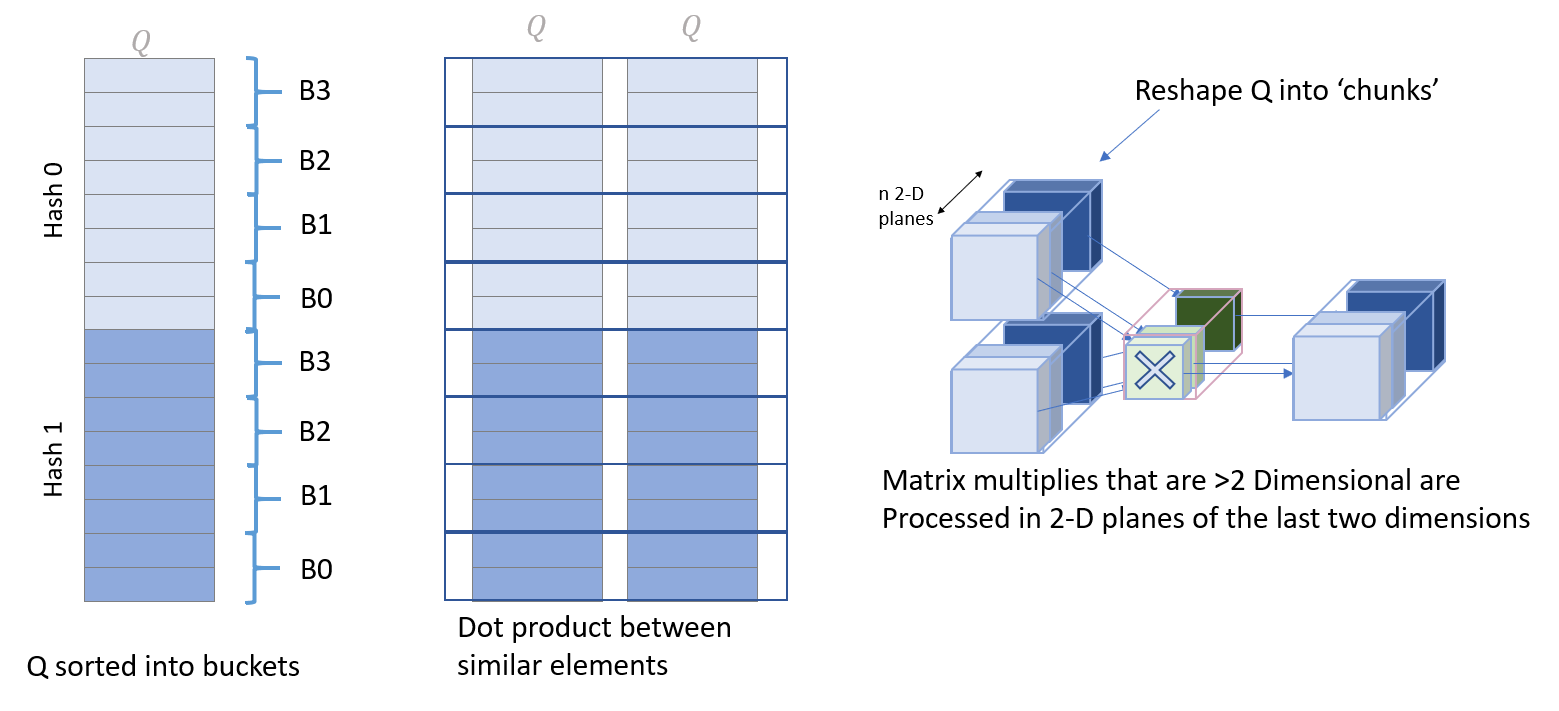</body></html>
<img src = "images/C4W4_LN2_image12.PNG" height="400" width="750">
<center><b>Figure 11: Performing dot product in 'chunks' </b></center>


The example we have been working on is shown above, with sequences of 8, 2 hashes, 4 buckets and, conveniently, the content of Q was such that when sorted, there were 2 entries in each bucket. If we reshape Q into a (8,2,n_q), we can use numpy matmul to perform the operation. Numpy [matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) will treat the inputs as a stack of matrices residing in the last two indexes. This will allow us to matrix multiply Q with itself in *chunks* and later can also be used to perform the matrix multiply with v.

We will perform a softmax on the output of the dot product of Q and Q, but in this case, there is a bit more to the story. Recall the output of the hash had multiple hash tables. We will perform softmax on those separately and then must combine them. This is where the form of softmax we defined at the top of the notebook comes into play. The routines below will utilize the `logsumexp` values that the `our_softmax` routine calculates.

There is a good deal of [reshaping](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to get things into the right formats. The code has many `print` statements that match the expected values below. You can use those to check your work as you go along. If you don't do a lot of 3-dimensional matrix multiplications in your daily life, it might be worthwhile to open a spare cell and practice a few simple examples to get the hang of it! Here is one to start with:


In [16]:
a = np.arange(16 * 3).reshape((16, 3))
chunksize = 2
ar = np.reshape(
    a, (-1, chunksize, a.shape[-1])
)  # the -1 usage is very handy, see numpy reshape
print(ar.shape)

(8, 2, 3)


**Instructions**

**Step 1** Reshaping Q
* np.reshape `sq` (sorted q) to be 3 dimensions. The middle dimension is the size of the 'chunk' specified by `kv_chunk_len`
* np.swapaxes to perform a 'transpose' on the reshaped `sq`, *but only on the last two dimensions*
* np.matmul the two values.

**Step 2**
* use our_softmax to perform the softmax on the dot product. Don't forget `passthrough`

**Step 3**
* np.reshape `sv`. Like `sq`, the middle dimension is the size of the 'chunk' specified by `kv_chunk_len`
* np.matmul dotlike and the reshaped `sv`
* np.reshape `so` to a two dimensional array with the last dimension stays the same (`so.shape[-1]`)
* `logits` also needs reshaping, we'll do that.

**Step 4** Now we can undo the sort.
* use [np.take](https://numpy.org/doc/stable/reference/generated/numpy.take.html) and `undo_sort` and `axis = 0` to unsort so
* do the same with `slogits`.

**Step 5** This step combines the results of multiple hashes. Recall, the softmax was only over the values in one hash, this extends it to all the hashes. Read through it, the code is provided. Note this is taking place *after* the matrix multiply with v while the softmax output is used before the multiply. How does this achieve the correct result?

In [17]:
def dotandv(
    sq, sv, undo_sort, kv_chunk_len, n_hashes, seqlen, passthrough, verbose=False
):
    # Step 1
    rsq = None
    rsqt = None
    if verbose:
        print("rsq.shape,rsqt.shape: ", rsq.shape, rsqt.shape)
    dotlike = None
    if verbose:
        print("dotlike\n", dotlike)

    # Step 2
    dotlike, slogits = None
    if verbose:
        print("dotlike post softmax\n", dotlike)

    # Step 3
    vr = None
    if verbose:
        print("dotlike.shape, vr.shape:", dotlike.shape, vr.shape)
    so = None
    if verbose:
        print("so.shape:", so.shape)
    so = None
    slogits = np.reshape(slogits, (-1,))  # provided
    if verbose:
        print("so.shape,slogits.shape", so.shape, slogits.shape)

    # Step 4
    o = None
    logits = None
    if verbose:
        print("o.shape,o", o.shape, o)
    if verbose:
        print("logits.shape, logits", logits.shape, logits)

    # Step 5 (Provided)
    if n_hashes > 1:
        o = np.reshape(o, (n_hashes, seqlen, o.shape[-1]))
        logits = np.reshape(logits, (n_hashes, seqlen, 1))
        probs = np.exp(logits - fastmath.logsumexp(logits, axis=0, keepdims=True))
        o = np.sum(o * probs, axis=0)

    return o

In [18]:
t_kv_chunk_len = 2
out = dotandv(
    t_sq,
    t_sv,
    t_undo_sort,
    t_kv_chunk_len,
    t_n_hashes,
    t_seqlen,
    passthrough=True,
    verbose=True,
)
print("out\n", out)
print("\n-----With softmax enabled----\n")
out = dotandv(
    t_sq,
    t_sv,
    t_undo_sort,
    t_kv_chunk_len,
    t_n_hashes,
    t_seqlen,
    passthrough=False,
    verbose=True,
)
print("out\n", out)

NameError: name 't_sq' is not defined

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Values**
```
rsq.shape,rsqt.shape:  (8, 2, 3) (8, 3, 2)
dotlike
 [[[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]

 [[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]]
dotlike post softmax
 [[[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]

 [[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]]
dotlike.shape, vr.shape: (8, 2, 2) (8, 2, 5)
so.shape: (8, 2, 5)
so.shape,slogits.shape (16, 5) (16,)
o.shape,o (16, 5) [[ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]
 [ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]
 [ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]
 [ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]]
logits.shape, logits (16,) [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
out
 [[ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]
 [ 0.  0.  0.  0.  0.]
 [ 6.  6.  6.  6.  6.]
 [24. 24. 24. 24. 24.]
 [54. 54. 54. 54. 54.]]

-----With softmax enabled----

rsq.shape,rsqt.shape:  (8, 2, 3) (8, 3, 2)
dotlike
 [[[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]

 [[ 0.  0.]
  [ 0.  0.]]

 [[ 3.  3.]
  [ 3.  3.]]

 [[12. 12.]
  [12. 12.]]

 [[27. 27.]
  [27. 27.]]]
dotlike post softmax
 [[[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.49999976 0.49999976]
  [0.49999976 0.49999976]]

 [[0.49999976 0.49999976]
  [0.49999976 0.49999976]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.5        0.5       ]
  [0.5        0.5       ]]

 [[0.49999976 0.49999976]
  [0.49999976 0.49999976]]

 [[0.49999976 0.49999976]
  [0.49999976 0.49999976]]]
dotlike.shape, vr.shape: (8, 2, 2) (8, 2, 5)
so.shape: (8, 2, 5)
so.shape,slogits.shape (16, 5) (16,)
o.shape,o (16, 5) [[1.        1.        1.        1.        1.       ]
 [1.        1.        1.        1.        1.       ]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [1.        1.        1.        1.        1.       ]
 [1.        1.        1.        1.        1.       ]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [1.        1.        1.        1.        1.       ]
 [1.        1.        1.        1.        1.       ]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [1.        1.        1.        1.        1.       ]
 [1.        1.        1.        1.        1.       ]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]
 [0.9999995 0.9999995 0.9999995 0.9999995 0.9999995]]
logits.shape, logits (16,) [ 0.6931472  3.6931472 12.693148  27.693148   0.6931472  3.6931472
 12.693148  27.693148   0.6931472  3.6931472 12.693148  27.693148
  0.6931472  3.6931472 12.693148  27.693148 ]
out
 [[1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.99999905 0.99999905 0.99999905 0.99999905 0.99999905]
 [0.99999905 0.99999905 0.99999905 0.99999905 0.99999905]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.99999905 0.99999905 0.99999905 0.99999905 0.99999905]
 [0.99999905 0.99999905 0.99999905 0.99999905 0.99999905]]
```

<details>
<summary>
    <font size="3" ><b>Completed code for reference </b></font>
</summary>

since this notebook is ungraded the completed code is provided here for reference:
    
```python
def dotandv(sq, sv, undo_sort, kv_chunk_len, n_hashes, seqlen, passthrough, verbose=False ):
    # Step 1
    rsq = np.reshape(sq,(-1, kv_chunk_len, sq.shape[-1]))
    rsqt =  np.swapaxes(rsq, -1, -2)
    if verbose: print("rsq.shape,rsqt.shape: ", rsq.shape,rsqt.shape)
    dotlike = np.matmul(rsq, rsqt)
    if verbose: print("dotlike\n", dotlike)

    #Step 2
    dotlike, slogits = our_softmax(dotlike, passthrough)
    if verbose: print("dotlike post softmax\n", dotlike)

    #Step 3
    vr = np.reshape(sv, (-1, kv_chunk_len, sv.shape[-1]))
    if verbose:  print("dotlike.shape, vr.shape:", dotlike.shape, vr.shape)
    so = np.matmul(dotlike, vr)
    if verbose: print("so.shape:", so.shape)
    so = np.reshape(so, (-1, so.shape[-1]))
    slogits = np.reshape(slogits, (-1,))  # provided
    if verbose: print("so.shape,slogits.shape", so.shape, slogits.shape)

    #Step 4
    o = np.take(so, undo_sort, axis=0)
    logits = np.take(slogits, undo_sort, axis=0)
    if verbose: print("o.shape,o", o.shape, o)
    if verbose: print("logits.shape, logits", logits.shape, logits)

    #Step 5 (Provided)
    if n_hashes > 1:
        o = np.reshape(o, (n_hashes, seqlen, o.shape[-1]))
        logits = np.reshape(logits, (n_hashes, seqlen, 1))
        probs = np.exp(logits - fastmath.logsumexp(logits, axis=0, keepdims=True))
        o = np.sum(o * probs, axis=0)

    return(o)
```

Great! You have now done examples code for most of the operation that are unique to the LSH version of self-attention. I'm sure at this point you are wondering what happens if the number of entries in a bucket is not evenly distributed the way our example is. It is possible, for example for all of the `seqlen` entries to land in one bucket. Further, since the buckets are not aligned, our 'chunks' may be misaligned with the start of the bucket. The implementation addresses this by attending to adjacent chunks as was described in the lecture:
<!DOCTYPE html><html><head><meta name="viewport" content="width=device-width, initial-scale=1"><style>img{display: block; margin-left: auto; margin-right: auto;}</style></head><body>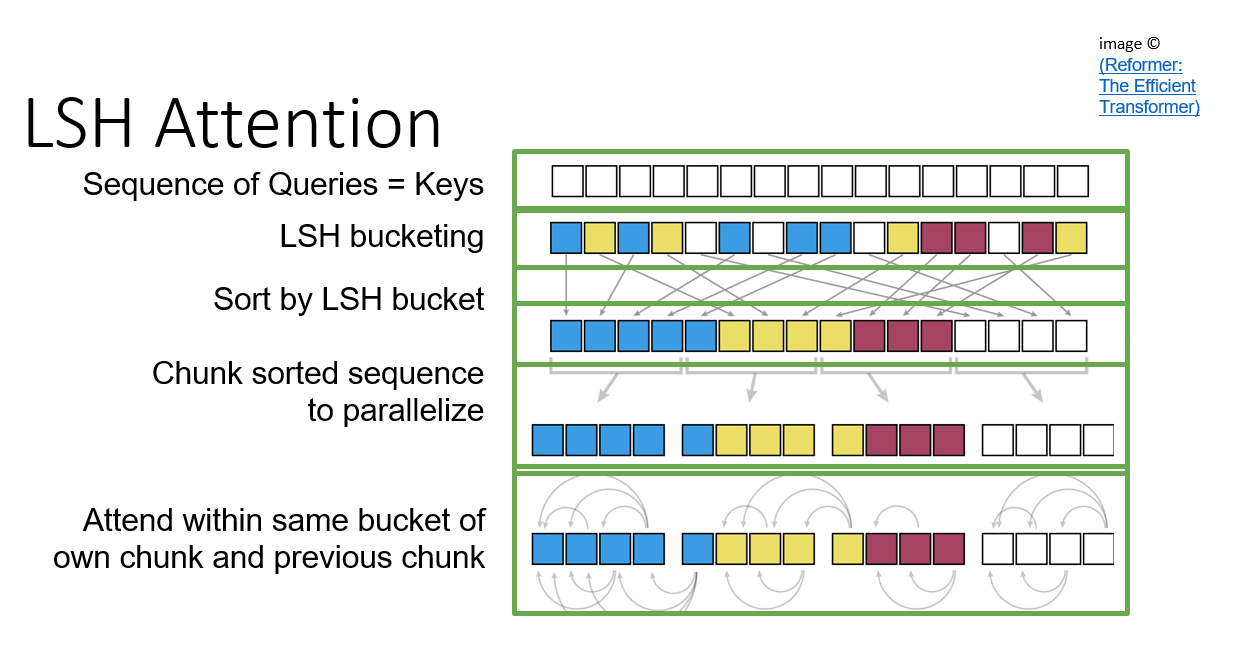</body></html>
<img src = "images/C4W4_LN2_image13.PNG" height="400" width="750">
<center><b>Figure 12: Misaligned Access, looking before and after </b></center>

Hopefully, having implemented parts of this, you will appreciate this diagram more fully.



<a name="3.5"></a>
## Part 3.5 OurLSHSelfAttention

You can examine the full implementations below. Area's we did not 'attend to' in our implementations above include variable bucket sizes and masking. We will instantiate a layer of the full implementation below. We tried to use the same variable names above to make it easier to decipher the full version. Note that some of the functionality we implemented in our routines is split between `attend` and `forward_unbatched`. We've inserted our version of hash below, but use the original version of `attend`.

In [ ]:
# original version from trax 1.3.4
def attend(
    q,
    k=None,
    v=None,
    q_chunk_len=None,
    kv_chunk_len=None,
    n_chunks_before=0,
    n_chunks_after=0,
    mask_fn=None,
    q_info=None,
    kv_info=None,
    dropout=0.0,
    rng=None,
):
    """Dot-product attention, with optional chunking and/or masking.

  Args:
    q: Query vectors, shape [q_len, d_qk]
    k: Key vectors, shape [kv_len, d_qk]; or None
    v: Value vectors, shape [kv_len, d_v]
    q_chunk_len: Set to non-zero to enable chunking for query vectors
    kv_chunk_len: Set to non-zero to enable chunking for key/value vectors
    n_chunks_before: Number of adjacent previous chunks to attend to
    n_chunks_after: Number of adjacent subsequent chunks to attend to
    mask_fn: TODO(kitaev) doc
    q_info: Query-associated metadata for masking
    kv_info: Key-associated metadata for masking
    dropout: Dropout rate
    rng: RNG for dropout

  Returns:
    A tuple (output, dots_logsumexp). The output has shape [q_len, d_v], and
    dots_logsumexp has shape [q_len]. The logsumexp of the attention
    probabilities is useful for combining multiple rounds of attention (as in
    LSH attention).
  """
    assert v is not None
    share_qk = k is None

    if q_info is None:
        q_info = np.arange(q.shape[-2], dtype=np.int32)

    if kv_info is None and not share_qk:
        kv_info = np.arange(v.shape[-2], dtype=np.int32)

    # Split q/k/v into chunks along the time axis, if desired.
    if q_chunk_len is not None:
        q = np.reshape(q, (-1, q_chunk_len, q.shape[-1]))
        q_info = np.reshape(q_info, (-1, q_chunk_len))

    if share_qk:
        assert kv_chunk_len is None or kv_chunk_len == q_chunk_len
        k = q
        kv_chunk_len = q_chunk_len
        if kv_info is None:
            kv_info = q_info
        elif kv_chunk_len is not None:
            # kv_info is not None, but reshape as required.
            kv_info = np.reshape(kv_info, (-1, kv_chunk_len))
    elif kv_chunk_len is not None:
        k = np.reshape(k, (-1, kv_chunk_len, k.shape[-1]))
        kv_info = np.reshape(kv_info, (-1, kv_chunk_len))

    if kv_chunk_len is not None:
        v = np.reshape(v, (-1, kv_chunk_len, v.shape[-1]))

    if share_qk:
        k = length_normalized(k)
    k = k / np.sqrt(k.shape[-1])

    # Optionally include adjacent chunks.
    if q_chunk_len is not None or kv_chunk_len is not None:
        assert q_chunk_len is not None and kv_chunk_len is not None
    else:
        assert n_chunks_before == 0 and n_chunks_after == 0

    k = look_adjacent(k, n_chunks_before, n_chunks_after)
    v = look_adjacent(v, n_chunks_before, n_chunks_after)
    kv_info = look_adjacent(kv_info, n_chunks_before, n_chunks_after)

    # Dot-product attention.
    dots = np.matmul(q, np.swapaxes(k, -1, -2))

    # Masking
    if mask_fn is not None:
        dots = mask_fn(dots, q_info[..., :, None], kv_info[..., None, :])

    # Softmax.
    dots_logsumexp = fastmath.logsumexp(dots, axis=-1, keepdims=True)
    dots = np.exp(dots - dots_logsumexp)

    if dropout > 0.0:
        assert rng is not None
        # Dropout is broadcast across the bin dimension
        dropout_shape = (dots.shape[-2], dots.shape[-1])
        #
        keep_prob = tie_in(dots, 1.0 - dropout)
        keep = fastmath.random.bernoulli(rng, keep_prob, dropout_shape)
        multiplier = keep.astype(dots.dtype) / tie_in(keep, keep_prob)
        dots = dots * multiplier

    # The softmax normalizer (dots_logsumexp) is used by multi-round LSH attn.
    out = np.matmul(dots, v)
    out = np.reshape(out, (-1, out.shape[-1]))
    dots_logsumexp = np.reshape(dots_logsumexp, (-1,))
    return out, dots_logsumexp

In [ ]:
class OurLSHSelfAttention(tl.LSHSelfAttention):
    """Our simplified LSH self-attention """

    def forward_unbatched(self, x, mask=None, *, weights, state, rng, update_state):
        attend_rng, output_rng = fastmath.random.split(rng)
        w_q, w_v, w_o = weights

        q = np.matmul(x, w_q)
        v = np.matmul(x, w_v)

        if update_state:
            _, old_hash_rng = state
            hash_rng, hash_subrng = fastmath.random.split(old_hash_rng)
            #      buckets = self.hash_vectors(q, hash_subrng, mask)  #  original
            ## use our version of hash
            buckets = our_hash_vectors(
                q, hash_subrng, self._n_buckets, self._n_hashes, mask=mask
            )
            s_buckets = buckets
            if self._max_length_for_buckets:
                length = self._n_hashes * self._max_length_for_buckets
                if buckets.shape[0] < length:
                    s_buckets = np.concatenate(
                        [buckets, np.zeros(length - buckets.shape[0], dtype=np.int32)],
                        axis=0,
                    )
            state = (s_buckets, hash_rng)
        else:
            buckets, _ = state
            if self._max_length_for_buckets:
                buckets = buckets[: self._n_hashes * x.shape[0]]

        seqlen = x.shape[0]
        assert int(buckets.shape[0]) == self._n_hashes * seqlen

        ticker = tie_in(x, np.arange(self._n_hashes * seqlen, dtype=np.int32))
        buckets_and_t = seqlen * buckets + (ticker % seqlen)
        buckets_and_t = fastmath.stop_gradient(buckets_and_t)

        # Hash-based sort ("s" at the start of variable names means "sorted")
        sbuckets_and_t, sticker = fastmath.sort_key_val(
            buckets_and_t, ticker, dimension=-1
        )
        _, undo_sort = fastmath.sort_key_val(sticker, ticker, dimension=-1)
        sbuckets_and_t = fastmath.stop_gradient(sbuckets_and_t)
        sticker = fastmath.stop_gradient(sticker)
        undo_sort = fastmath.stop_gradient(undo_sort)

        st = sticker % seqlen
        sq = np.take(q, st, axis=0)
        sv = np.take(v, st, axis=0)

        mask_fn = functools.partial(
            mask_self_attention,
            causal=self._causal,
            exclude_self=True,
            masked=self._masked,
        )
        q_info = st

        assert (mask is not None) == self._masked
        kv_info = None
        if self._masked:
            # mask is a boolean array (True means "is valid token")
            smask = np.take(mask, st, axis=0)
            ones_like_mask = tie_in(x, np.ones_like(smask, dtype=np.int32))
            kv_info = q_info * np.where(smask, ones_like_mask, -ones_like_mask)

        ## use original version of attend (could use ours but lacks masks and masking)
        so, slogits = attend(
            sq,
            k=None,
            v=sv,
            q_chunk_len=self._chunk_len,
            n_chunks_before=self._n_chunks_before,
            n_chunks_after=self._n_chunks_after,
            mask_fn=mask_fn,
            q_info=q_info,
            kv_info=kv_info,
            dropout=self._attention_dropout,
            rng=attend_rng,
        )

        # np.take(so, undo_sort, axis=0); np.take(slogits, undo_sort, axis=0) would
        # also work, but these helpers include performance optimizations for TPU.
        o = permute_via_gather(so, undo_sort, sticker, axis=0)
        logits = permute_via_sort(slogits, sticker, buckets_and_t, axis=-1)

        if self._n_hashes > 1:
            o = np.reshape(o, (self._n_hashes, seqlen, o.shape[-1]))
            logits = np.reshape(logits, (self._n_hashes, seqlen, 1))
            probs = np.exp(logits - fastmath.logsumexp(logits, axis=0, keepdims=True))
            o = np.sum(o * probs, axis=0)

        assert o.shape == (seqlen, w_v.shape[-1])
        out = np.matmul(o, w_o)
        out = apply_broadcasted_dropout(out, self._output_dropout, output_rng)
        return out, state

In [ ]:
# Here we're going to try out our LSHSelfAttention
n_heads = 3
causal = False
masked = False
mask = None
chunk_len = 8
n_chunks_before = 0
n_chunks_after = 0
attention_dropout = 0.0
n_hashes = 5
n_buckets = 4
seq_len = 8
emb_len = 5
al = OurLSHSelfAttention(
    n_heads=n_heads,
    d_qk=3,
    d_v=4,
    causal=causal,
    chunk_len=8,
    n_chunks_before=n_chunks_before,
    n_chunks_after=n_chunks_after,
    n_hashes=n_hashes,
    n_buckets=n_buckets,
    use_reference_code=True,
    attention_dropout=attention_dropout,
    mode="train",
)

x = jax.random.uniform(jax.random.PRNGKey(0), (1, seq_len, emb_len), dtype=np.float32)
al_osa = fastmath.random.get_prng(1)
_, _ = al.init(tl.shapes.signature(x), rng=al_osa)

In [ ]:
al(x)

<details>
<summary>
    <font size="3"><b> Expected Output </b></font>
</summary>

**Expected Values**
```
DeviceArray([[[ 6.6842866e-01, -1.1364317e-01, -5.4430598e-01,
                2.1126229e-01, -1.0988474e-02],
              [ 7.0949805e-01, -1.5455173e-01, -5.9923279e-01,
                2.2719435e-01,  1.3833910e-02],
              [ 7.1442688e-01, -1.2046629e-01, -5.3956538e-01,
                1.7320301e-01, -1.6552359e-02],
              [ 6.7178923e-01, -7.6611072e-02, -5.9399861e-01,
                2.1236289e-01,  7.9482794e-04],
              [ 7.1518469e-01, -1.1359149e-01, -5.7821870e-01,
                2.1304403e-01,  3.0598417e-02],
              [ 6.8235356e-01, -9.3979865e-02, -5.5341852e-01,
                2.1608178e-01, -6.6673756e-04],
              [ 6.1286646e-01, -8.1026971e-02, -4.8148811e-01,
                1.9373316e-01,  3.1555206e-02],
              [ 7.2203499e-01, -1.0199657e-01, -5.5215180e-01,
                1.7872262e-01, -2.2289127e-02]]], dtype=float32)
```

**Congratuations!** you have created a custom layer and have become familiar with LSHSelfAttention.